Обучить сиамскую сеть для верификации лиц на датасете LFW

Библиотеки: [Python, Tensorflow]

In [2]:
# !pip install tensorflow_datasets

In [1]:
import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_datasets as tfds

### Загрузка данных.

In [3]:
dataset, ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    data_dir='../lesson_06/LFW', 
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='../lesson_06/LFW/lfw/0.1.0',
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
  

In [5]:
dataset = dataset['train']

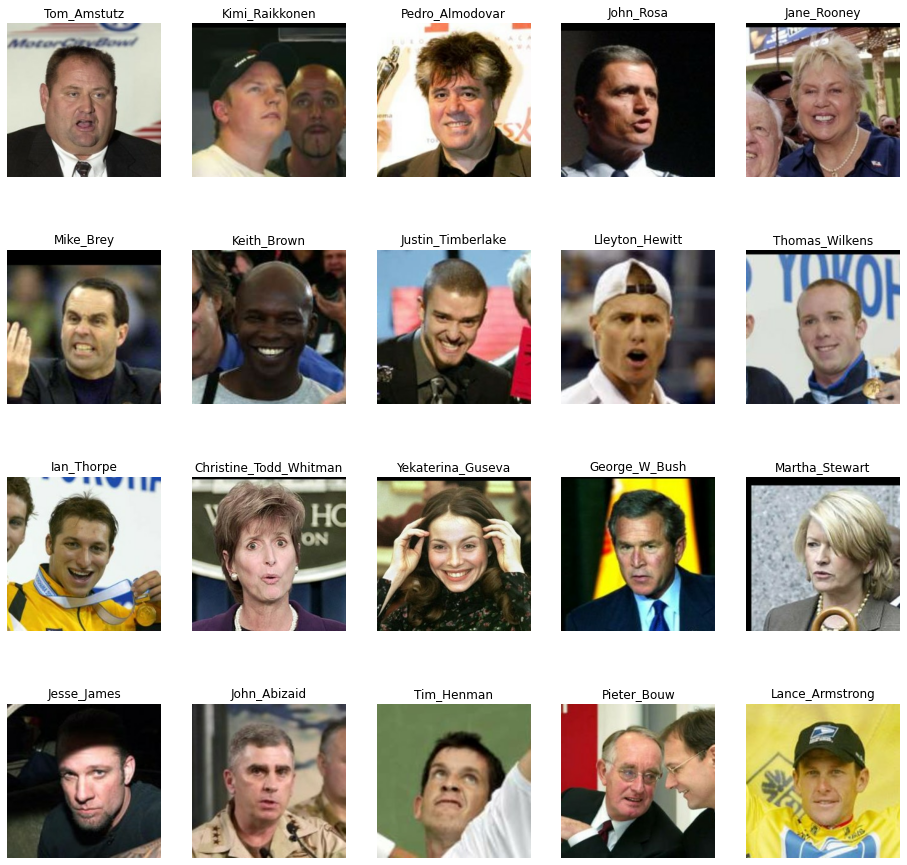

In [6]:
shape = (4, 5)
width = 16

fig, ax = plt.subplots(*shape, figsize=(width, shape[0] * (width//shape[1] + 1)))

for i, (label, img) in enumerate(iter(dataset.take(np.prod(shape)))):
    pos = ax[i//shape[1], i%shape[1]]
    pos.imshow(img)
    pos.set_title(label.numpy().decode())
    pos.axis('off')
plt.show()

### Подготовка данных.

In [7]:
INPUT_DIM = 128
NUM_EPOCHS = 10
HALF_BATCH_SIZE = 4
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 1e-4


def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INPUT_DIM, INPUT_DIM))


dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat(NUM_EPOCHS)
dataset = dataset.map(prepare)
dataset = dataset.batch(HALF_BATCH_SIZE, drop_remainder=True)

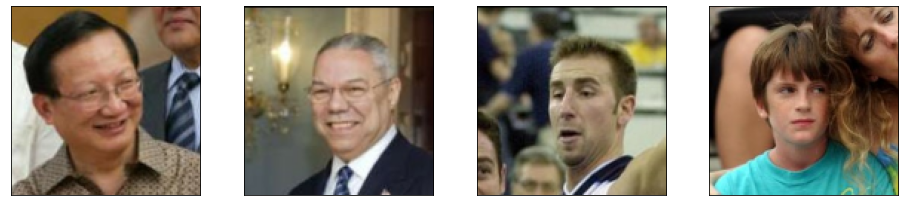

In [8]:
def plot_images(samples):
    fig = plt.figure(figsize=(16, 16))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(4, 4, j+1)
        ax.imshow(samples[j, ...])
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_images(next(iter(dataset.take(1))))

### Построение модели.

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [12]:
generator = tf.keras.Sequential([
    layers.Dense(256*32*32),
    layers.Dropout(0.1),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((32, 32, 256)),
    layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),   
    layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'),
])


discriminator = tf.keras.Sequential([
    layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(0.2), 
    layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(256, kernel_size=2, strides=(1, 1), padding='same'),
    layers.BatchNormalization(momentum=0.8),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dropout(0.25),
    layers.Dense(1),
])

### Обучение модели.

In [13]:
LEARNING_RATE = 1e-4

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.6942; G Loss: 0.7403


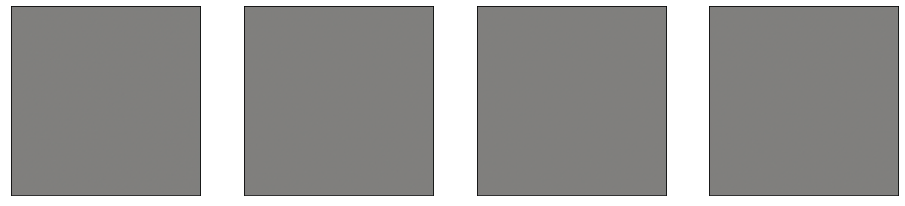

[Step 3000] D Loss: 0.6105; G Loss: 0.6241


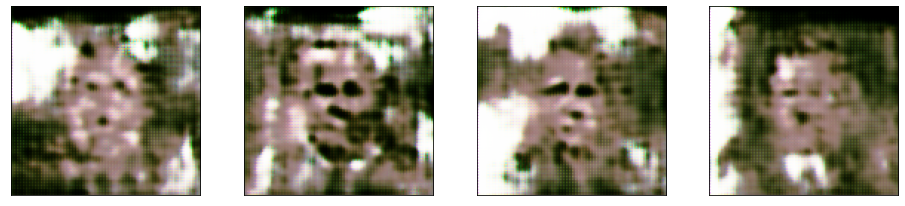

[Step 6000] D Loss: 1.0749; G Loss: 0.6589


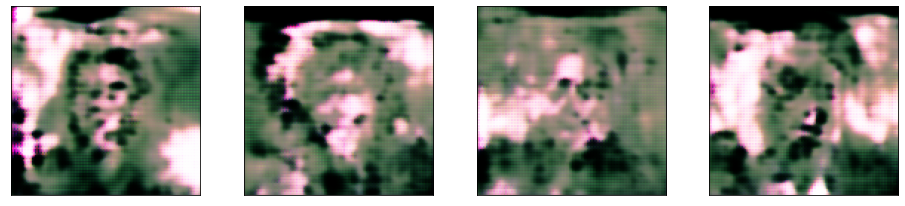

[Step 9000] D Loss: 0.7355; G Loss: 0.7333


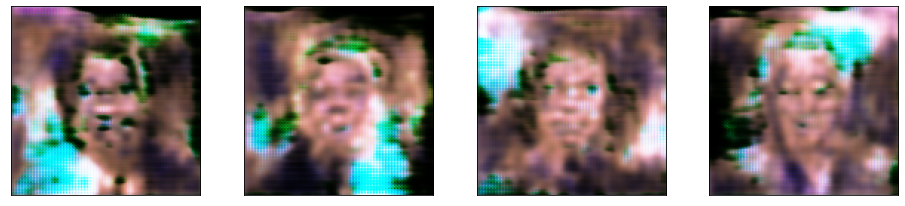

[Step 12000] D Loss: 0.5500; G Loss: 0.9066


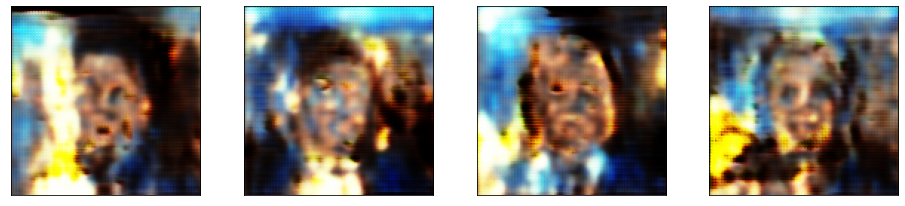

[Step 15000] D Loss: 0.5499; G Loss: 1.1318


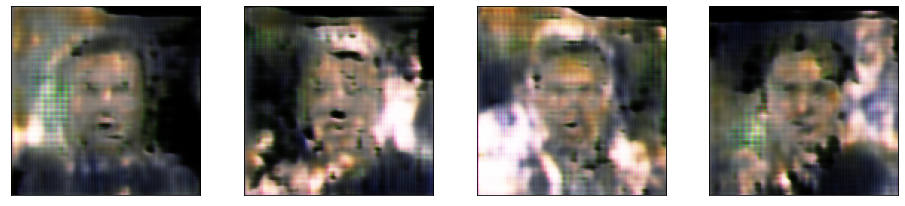

[Step 18000] D Loss: 0.5675; G Loss: 0.8793


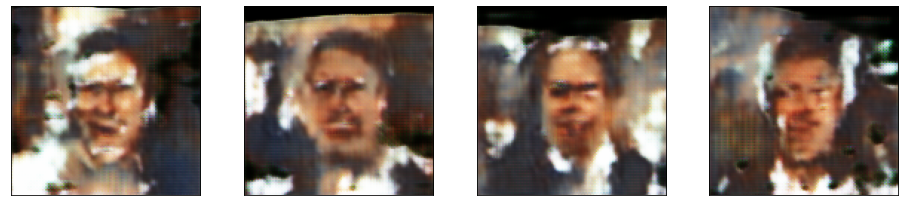

[Step 21000] D Loss: 0.7500; G Loss: 1.4569


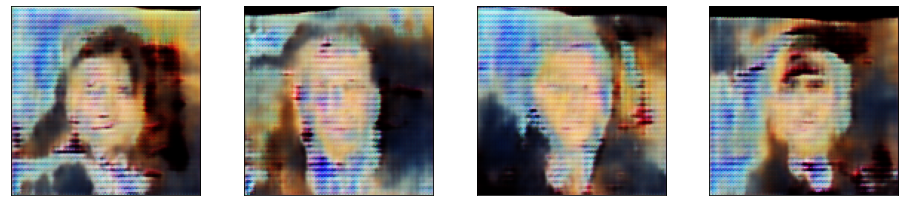

[Step 24000] D Loss: 0.2107; G Loss: 1.6002


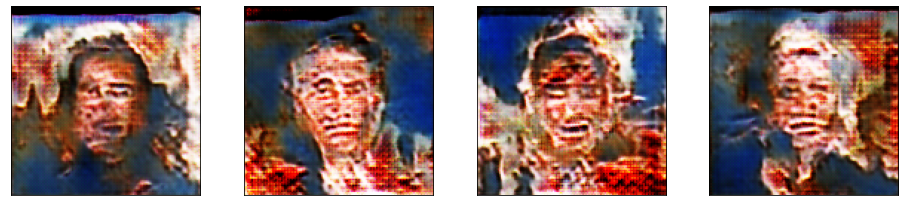

[Step 27000] D Loss: 0.3674; G Loss: 2.0312


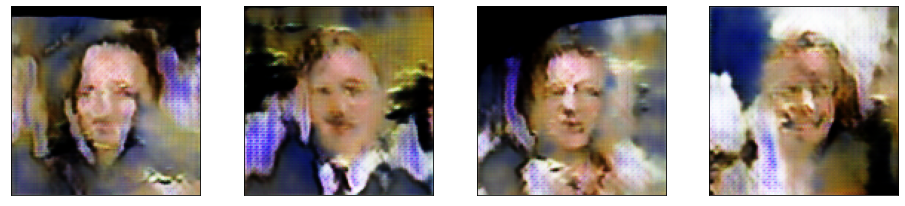

[Step 30000] D Loss: 0.6428; G Loss: 1.9125


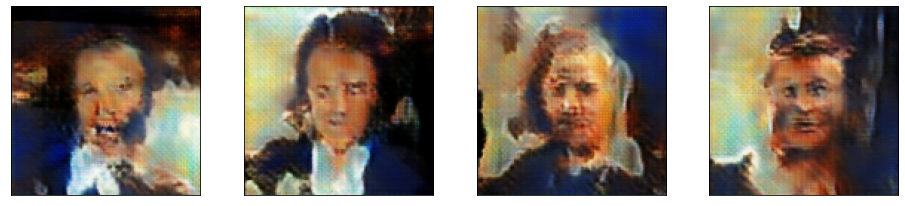

[Step 33000] D Loss: 0.1745; G Loss: 1.8627


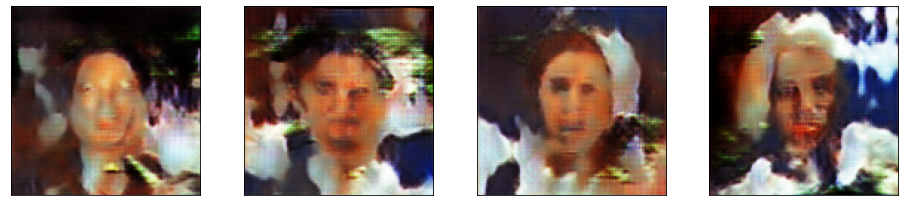

In [14]:
for step, true_images in enumerate(dataset):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 3000 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (4, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

### Инференс модели.

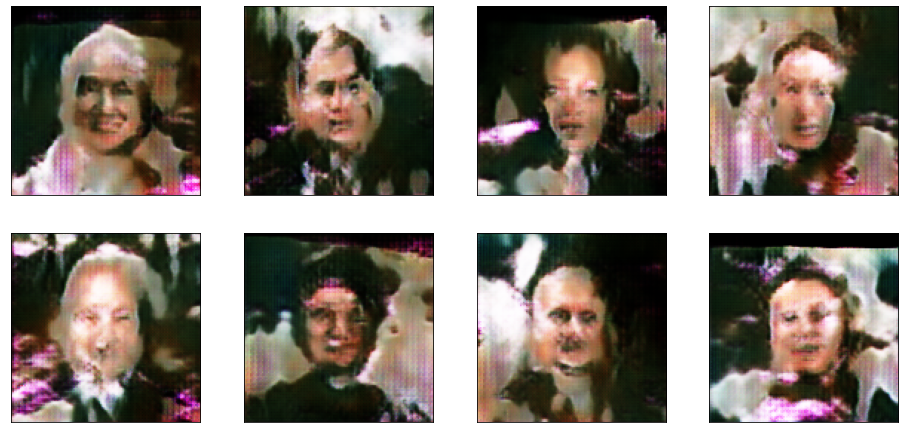

In [17]:
noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)